# EDA of datasets provided by Kaggle
The purpose of this notebook is to explore each of the datasets provided by Kaggle.
The output will be:
- comments assisting with the general understanding of the data available
- interesting insights that may influence modelling
- recommendations for feature engineering

## Train
Note, this is the largest dataset and the assumption is most of the feature engineering will be built around this dataset.

In [ ]:
from config import proj
from pyspark.sql import SparkSession
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.pandas as ps
import calendar
import pyspark.sql.functions as sf
import warnings

warnings.filterwarnings('ignore')

spark = SparkSession.builder.getOrCreate()
train = spark.read.parquet(str(proj.Config.paths.get("data_proc").joinpath("train.parquet")))

In [2]:
train.show(5)

+----------+---------+--------+----------+-----------+
|      date|store_nbr|item_nbr|unit_sales|onpromotion|
+----------+---------+--------+----------+-----------+
|2013-04-06|       49|  586969|       7.0|       null|
|2013-04-06|       49|  587069|      21.0|       null|
|2013-04-06|       49|  587156|       6.0|       null|
|2013-04-06|       49|  587186|      22.0|       null|
|2013-04-06|       49|  589403|       9.0|       null|
+----------+---------+--------+----------+-----------+
only showing top 5 rows



Initial ideas
- date range
- any missing dates
- counts of stores, items
- unit sales distribution (overall)
- onpromo distribution over all
- time series plot (any seasonality)
- STL decomposition (trends seasonality)
- check for stationality (mean and variance stationary in time)
- missing promo flags (suggestion of treatment)
- checks for autocorrelation and partial autocorrelation

### Overview
Start by having a quick overview of the data:
- date range
- missing dates
- total and average sales plot
- max and min total sales
- distribution of total sales
- returns time series
- counts of stores, items, etc

#### Date range and total sales

In [3]:
sales_total = train.select("date", "unit_sales")\
    .groupby(train.date)\
    .agg(sf.sum('unit_sales').alias('total_unit_sales'))\
    .toPandas()

In [4]:
print(sales_total.date.min())
print(sales_total.date.max())
print(sales_total.total_unit_sales.min())
print(sales_total.total_unit_sales.max())

2013-01-01
2017-08-15
2511.6190002560616
1463083.9631341696


4.5 years worth of timeseries data, will likely not need this much for the model training.

unit sales is either weight or units sold rather than dollars (as mentioned on Kaggle)

Suggestion:
- Start with 2 years worth of data when modeling, this should give enough information about seasonality.

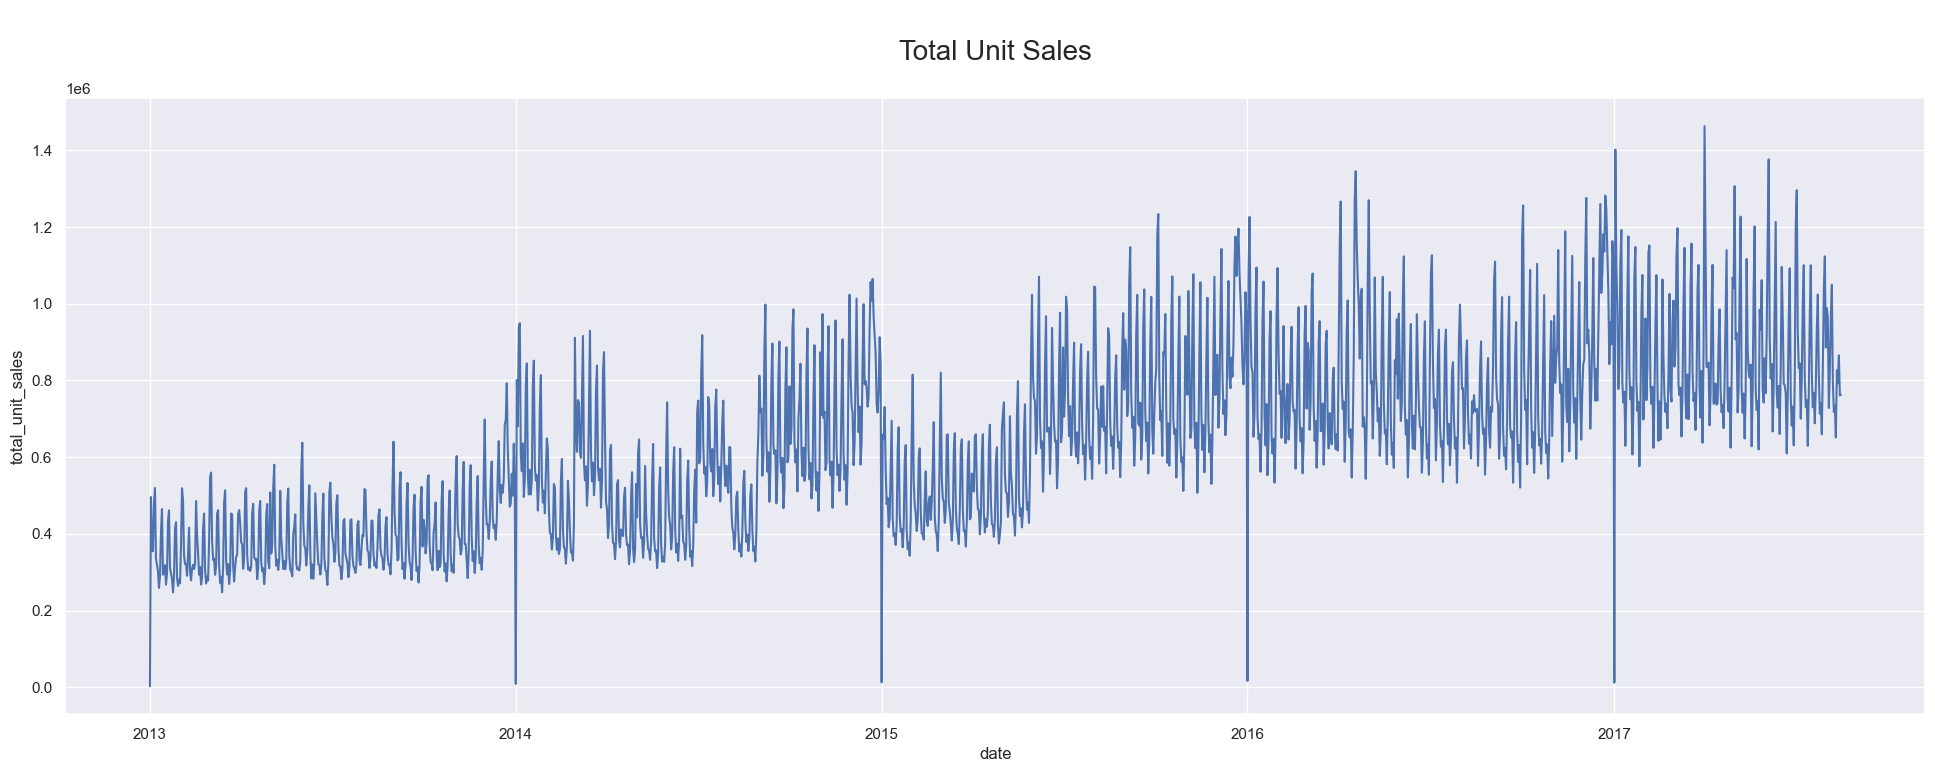

In [5]:
sns.set(rc={"figure.figsize":(24,8)})
ax=sns.lineplot(data=sales_total,x="date",y="total_unit_sales")
ax.axes.set_title("\nTotal Unit Sales\n",fontsize=20);

#### Max and min total sales

In [6]:
print(sales_total[sales_total.total_unit_sales == sales_total.total_unit_sales.min()])
sales_total.sort_values('total_unit_sales').head(10)

           date  total_unit_sales
218  2013-01-01          2511.619


,date,total_unit_sales
218,2013-01-01,2511.619000
315,2014-01-01,8602.065404
597,2017-01-01,12082.500986
1226,2015-01-01,12773.616996
903,2016-01-01,16433.394001
251,2013-01-24,247245.691038
129,2013-03-14,247541.420012
244,2013-01-10,258982.003025
225,2013-01-29,264488.818018
296,2013-06-27,266525.458982


In [7]:
print(sales_total[sales_total.total_unit_sales == sales_total.total_unit_sales.max()])
sales_total.sort_values('total_unit_sales', ascending=False).head(10).round(2)

            date  total_unit_sales
1047  2017-04-01      1.463084e+06


,date,total_unit_sales
1047,2017-04-01,1463083.96
684,2017-01-02,1402305.37
1039,2017-06-04,1376511.52
591,2016-04-18,1345920.60
1045,2017-05-01,1306699.37
1012,2017-07-02,1296379.22
707,2016-12-23,1282145.52
455,2016-12-04,1276195.04
652,2016-04-17,1271833.74
632,2016-05-01,1270121.21


Clear trend upwards throughout the period. Likely due to additional stores, but could also be due to additional foot traffic in stores.

Can see a dip every year on new year's day. Most stores are probably shut on this day.

Large sale days don't show much of a pattern. But could be around Christmas or Easter. Will need to check this with the holiday data.

#### Monthly and yearly total sales

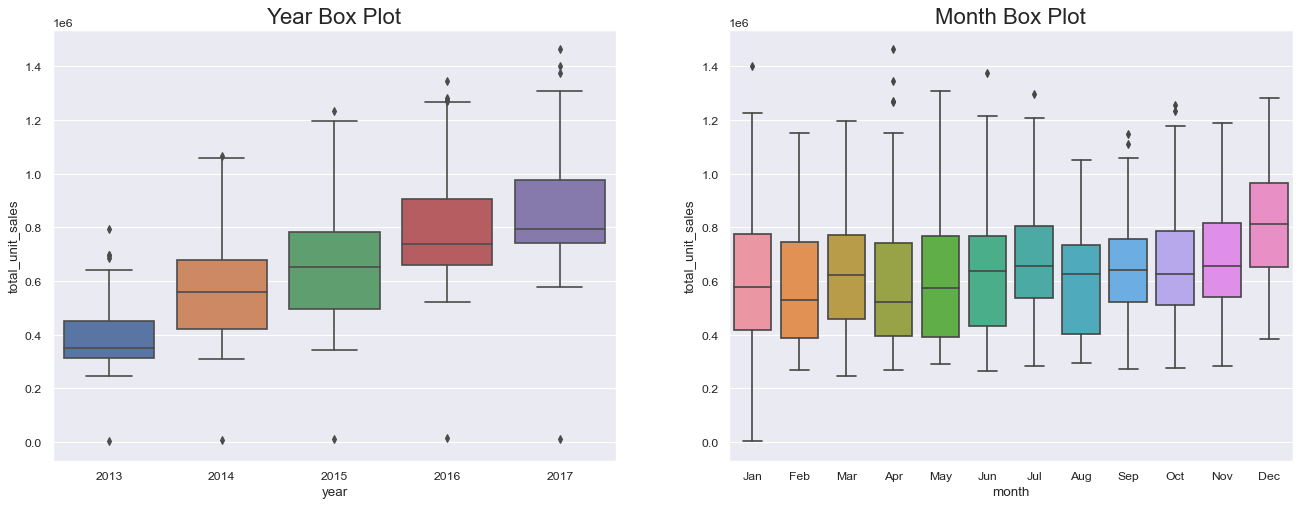

In [8]:
# Prepare data
sales_total['year'] = [d.year for d in sales_total.date]
sales_total['month'] = [d.strftime('%b') for d in sales_total.date]
years = sales_total['year'].unique()
month_full_list = list(calendar.month_name)
month_order = [month[0:3] for month in month_full_list if len(month) > 1]

# Draw plots
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='total_unit_sales', data=sales_total, ax=axes[0])
sns.boxplot(x='month', y='total_unit_sales', data=sales_total, order=month_order)

# Set titles
axes[0].set_title('Year Box Plot', fontsize=20);
axes[1].set_title('Month Box Plot', fontsize=20)
plt.show()

Nothing too interesting, total sales pick up in Dec. Jan as a normal median and interquartile range but lower minimum which agrees with findings above.

Yearly sales increase as first seen in time series plot

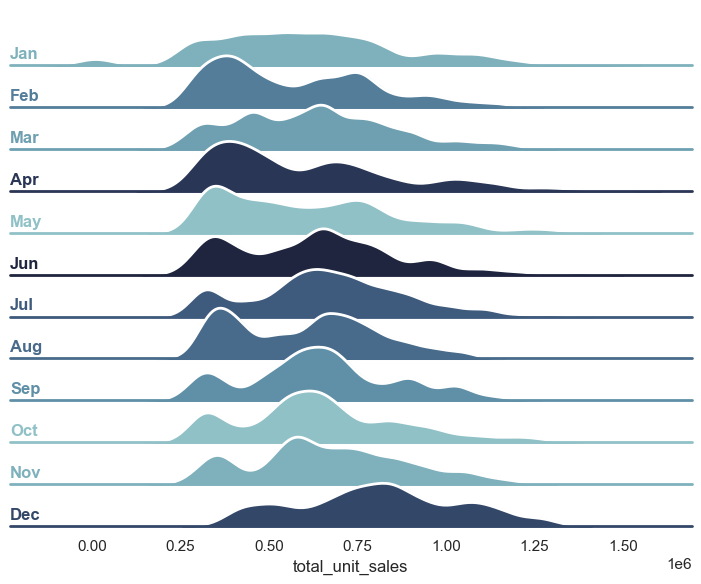

In [9]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(sales_total, row="month", hue="month", aspect=15, height=.5, palette=pal,row_order=month_order)

# Draw the densities in a few steps
g.map(sns.kdeplot, "total_unit_sales", bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)

# Add lines around distributions
g.map(sns.kdeplot, "total_unit_sales", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Label the plot in axes
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)
g.map(label, "total_unit_sales")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

Distribution of months gives a bit more detail but nothing too interesting. The multiple peaks are likely caused by the different years.

#### Average sales

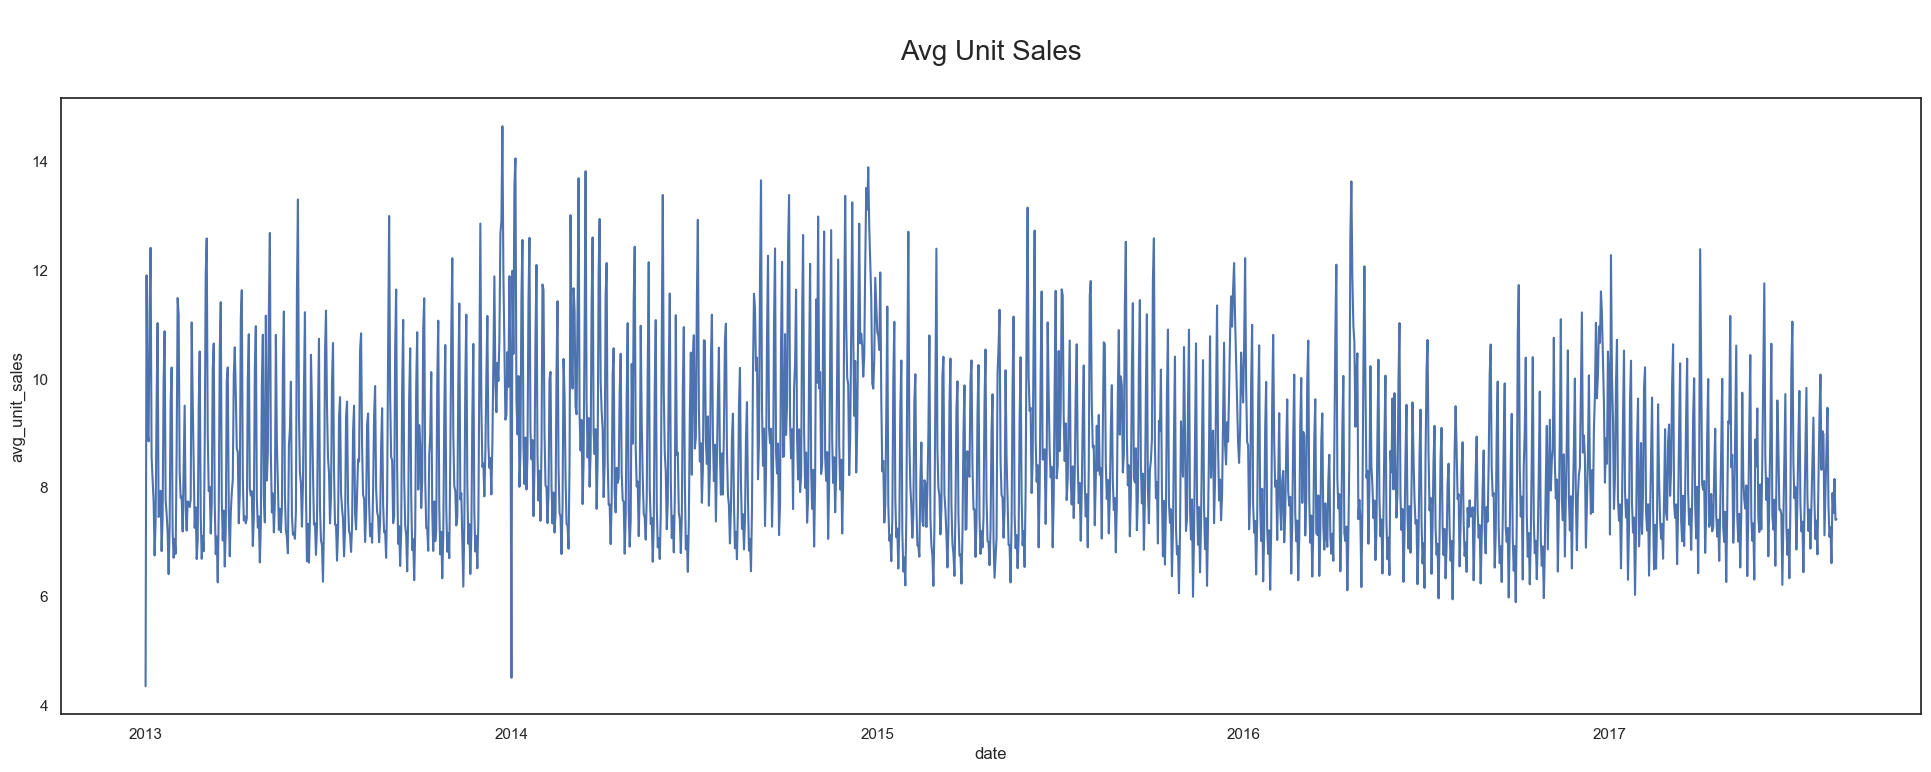

In [10]:
sales_avg = train.select("date", "unit_sales")\
    .groupby(train.date)\
    .agg(sf.avg("unit_sales").alias("avg_unit_sales"))\
    .toPandas()

ax=sns.lineplot(data=sales_avg,x="date",y="avg_unit_sales")
ax.axes.set_title("\nAvg Unit Sales\n",fontsize=20);

Average sales per day seems pretty consistent, variance reduces a little bit by the looks of it

Can see spikes around Christmas.

#### Total returns

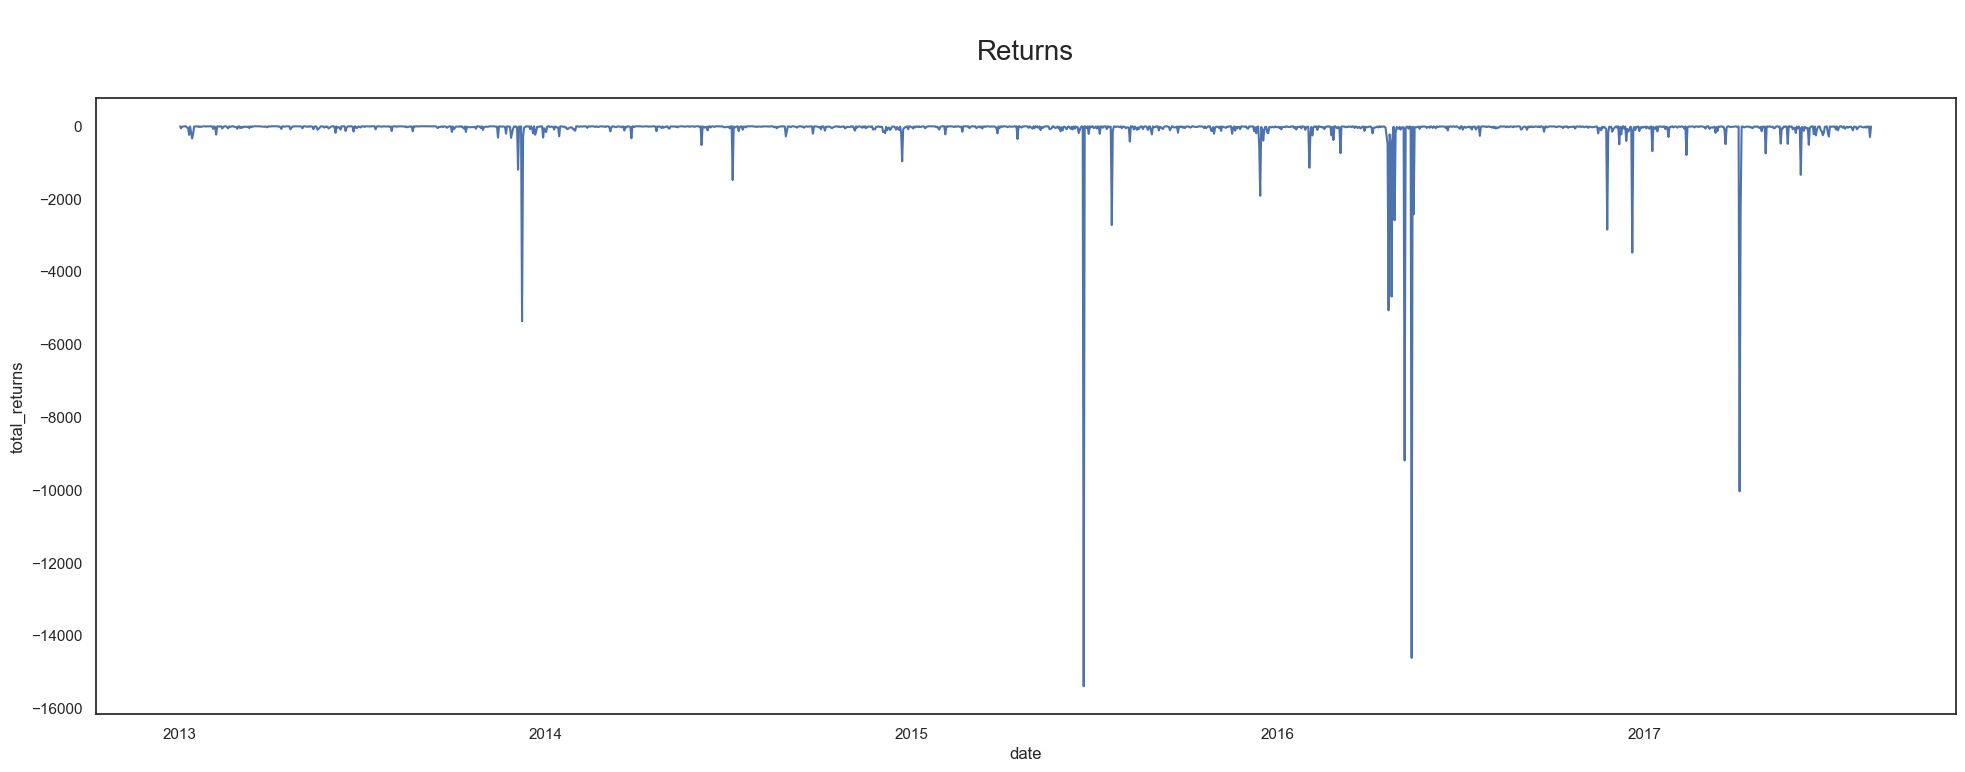

In [11]:
returns = train.select("date", "unit_sales")\
    .filter(train.unit_sales < 0)\
    .groupby(train.date)\
    .agg(sf.sum("unit_sales").alias("total_returns"))\
    .toPandas()

ax=sns.lineplot(data=returns,x="date",y="total_returns")
ax.axes.set_title("\nReturns\n",fontsize=20);

In [12]:
returns.sort_values('total_returns').head(10).round(2)

,date,total_returns
1177,2015-06-22,-15384.91
745,2016-05-14,-14607.00
912,2017-04-06,-10029.24
504,2016-05-07,-9181.00
305,2013-12-09,-5357.00
628,2016-04-21,-5055.58
601,2016-04-24,-4679.00
515,2016-12-20,-3471.36
319,2016-11-25,-2839.00
1281,2015-07-20,-2714.09


No obvious pattern with the returns, but looks to be a spikes/clusters of period where there are a large amounts of returns.
Could investigate further into the products and stores this impacted, but this will be easier if we start putting together a feature store.

#### Item and store counts

In [13]:
print("Unique items: " + str(train.select("item_nbr").distinct().count()))
print("Unique stores: " + str(train.select("store_nbr").distinct().count()))

Unique items: 4036


Unique stores: 54


#### Decomposition

Figure(2400x800)


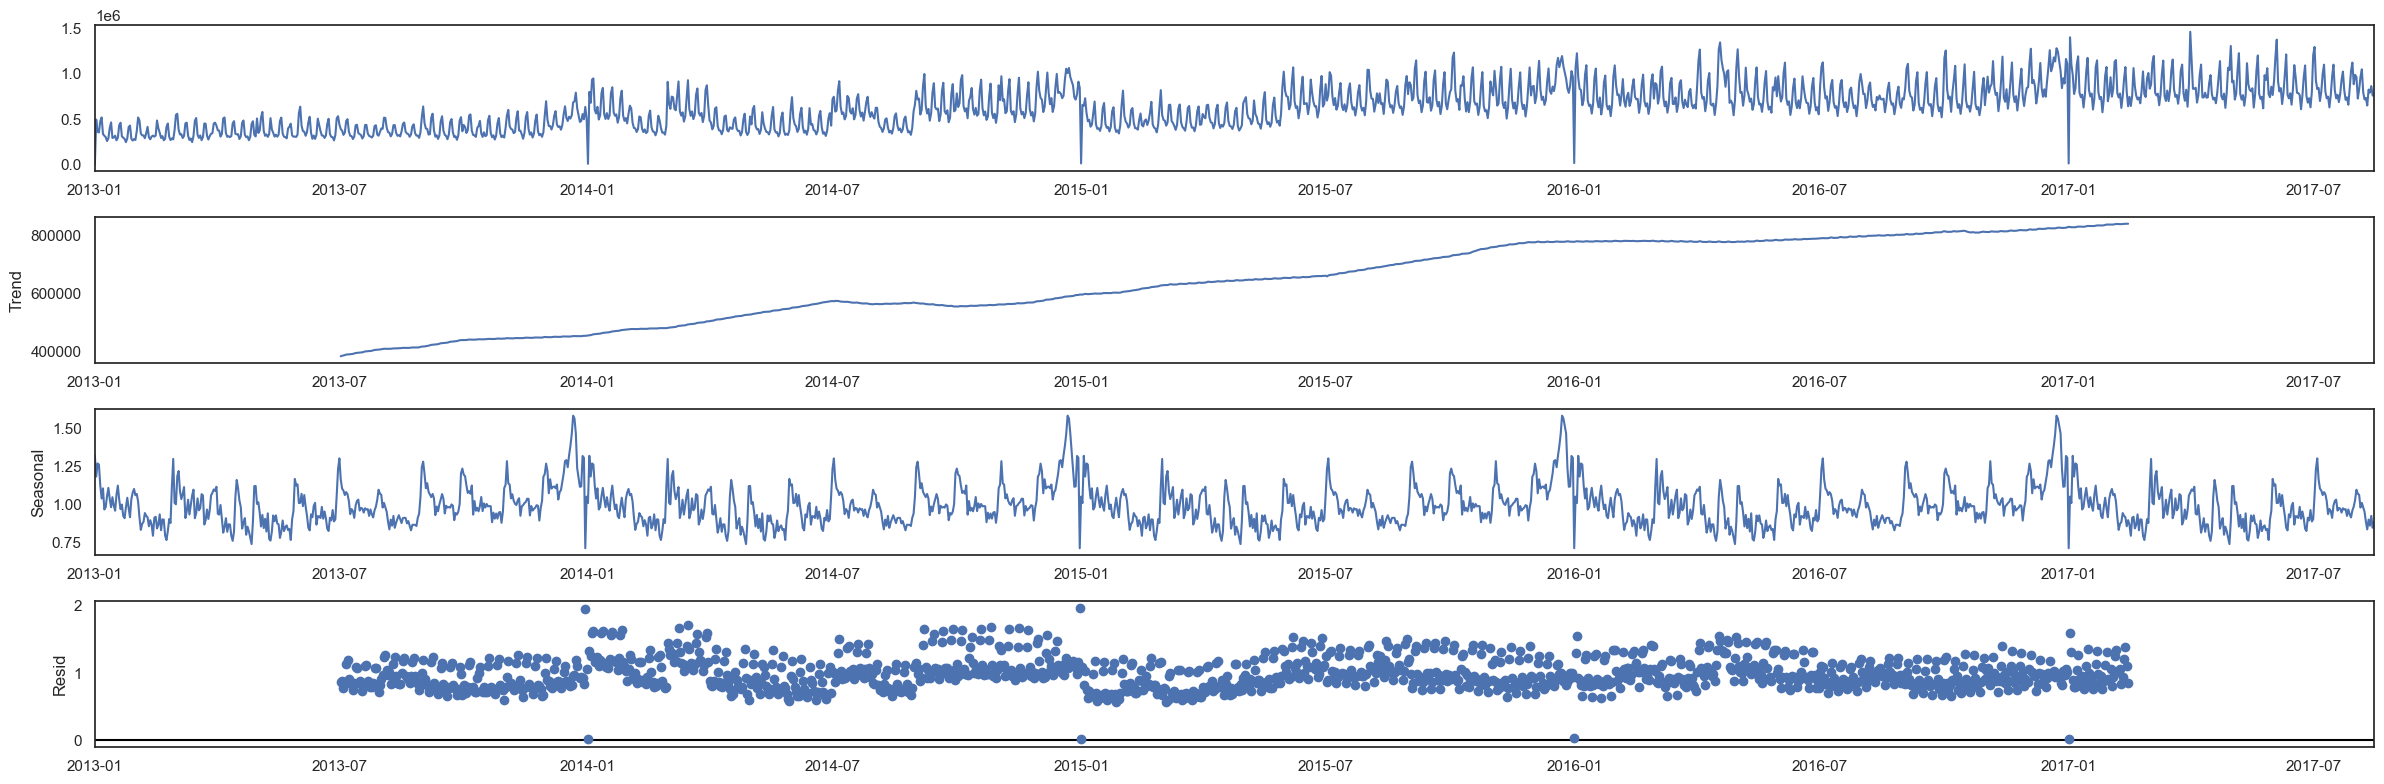

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

sales_stl = sales_total.sort_values(by='date', inplace=False)
sales_stl = sales_stl.set_index('date')

# using multiplicative model since it looks like the trend has increased over time.
result = seasonal_decompose(sales_stl[["total_unit_sales"]], model='multiplicable', period=365)
print(result.plot())

Not very useful: trend is increasing, seasonality looks consistent and there is a lot of residual.

## Explore each of the subsequent datasets

In [15]:
train.show(5)

+----------+---------+--------+----------+-----------+
|      date|store_nbr|item_nbr|unit_sales|onpromotion|
+----------+---------+--------+----------+-----------+
|2013-04-06|       49|  586969|       7.0|       null|
|2013-04-06|       49|  587069|      21.0|       null|
|2013-04-06|       49|  587156|       6.0|       null|
|2013-04-06|       49|  587186|      22.0|       null|
|2013-04-06|       49|  589403|       9.0|       null|
+----------+---------+--------+----------+-----------+
only showing top 5 rows



### Items

In [16]:
items = spark.read.parquet(str(proj.Config.paths.get("data_proc").joinpath("items.parquet")))
items.show(5)

+--------+------------+-----+----------+
|item_nbr|      family|class|perishable|
+--------+------------+-----+----------+
|   96995|   GROCERY I| 1093|         0|
|   99197|   GROCERY I| 1067|         0|
|  103501|    CLEANING| 3008|         0|
|  103520|   GROCERY I| 1028|         0|
|  103665|BREAD/BAKERY| 2712|         1|
+--------+------------+-----+----------+
only showing top 5 rows



In [17]:
print("unique items: " + str(items.select("item_nbr").distinct().count()))
print("unique item families: " + str(items.select("family").distinct().count()))
print("unique item classes: " + str(items.select("class").distinct().count()))
items.select("perishable").groupby("perishable").count().show()

unique items: 4100
unique item families: 33
unique item classes: 337
+----------+-----+
|perishable|count|
+----------+-----+
|         1|  986|
|         0| 3114|
+----------+-----+



More items in this dataset than in train. Can assume test will have unseen items.

Most items are non-perishable.

### Holidays

In [18]:
holidays = spark.read.parquet(str(proj.Config.paths.get("data_proc").joinpath("holidays_events.parquet")))
holidays.show(5)

+----------+-------+--------+-----------+--------------------+-----------+
|      date|   type|  locale|locale_name|         description|transferred|
+----------+-------+--------+-----------+--------------------+-----------+
|2012-03-02|Holiday|   Local|      Manta|  Fundacion de Manta|      false|
|2012-04-01|Holiday|Regional|   Cotopaxi|Provincializacion...|      false|
|2012-04-12|Holiday|   Local|     Cuenca| Fundacion de Cuenca|      false|
|2012-04-14|Holiday|   Local|   Libertad|Cantonizacion de ...|      false|
|2012-04-21|Holiday|   Local|   Riobamba|Cantonizacion de ...|      false|
+----------+-------+--------+-----------+--------------------+-----------+
only showing top 5 rows



In [19]:
holidays.groupby("type").count().show()
holidays.groupby("locale").count().show()
holidays.groupby("transferred").count().show()

+----------+-----+
|      type|count|
+----------+-----+
|     Event|   56|
|   Holiday|  221|
|  Transfer|   12|
|    Bridge|    5|
|Additional|   51|
|  Work Day|    5|
+----------+-----+

+--------+-----+
|  locale|count|
+--------+-----+
|National|  174|
|   Local|  152|
|Regional|   24|
+--------+-----+

+-----------+-----+
|transferred|count|
+-----------+-----+
|       true|   12|
|      false|  338|
+-----------+-----+



Transfers don't occur often.

Most holidays are national and local.

### Stores

In [20]:
stores = spark.read.parquet(str(proj.Config.paths.get("data_proc").joinpath("stores.parquet")))
stores.show(5)

+---------+-------------+--------------------+----+-------+
|store_nbr|         city|               state|type|cluster|
+---------+-------------+--------------------+----+-------+
|        1|        Quito|           Pichincha|   D|     13|
|        2|        Quito|           Pichincha|   D|     13|
|        3|        Quito|           Pichincha|   D|      8|
|        4|        Quito|           Pichincha|   D|      9|
|        5|Santo Domingo|Santo Domingo de ...|   D|      4|
+---------+-------------+--------------------+----+-------+
only showing top 5 rows



In [21]:
print("Unique stores: " + str(stores.select("store_nbr").distinct().count()))
print("Unique cities: " + str(stores.select("city").distinct().count()))
print("Unique states: " + str(stores.select("state").distinct().count()))

Unique stores: 54
Unique cities: 22
Unique states: 16


In [22]:
stores.groupby("state").count().show()
stores.groupby("type").count().show()
stores.groupby("cluster").count().show()

+--------------------+-----+
|               state|count|
+--------------------+-----+
|              Manabi|    3|
|            Cotopaxi|    2|
|           Pichincha|   19|
|          Chimborazo|    1|
|              Guayas|   11|
|                Loja|    1|
|         Santa Elena|    1|
|            Imbabura|    1|
|              El Oro|    2|
|               Azuay|    3|
|             Bolivar|    1|
|          Tungurahua|    2|
|             Pastaza|    1|
|Santo Domingo de ...|    3|
|            Los Rios|    2|
|          Esmeraldas|    1|
+--------------------+-----+

+----+-----+
|type|count|
+----+-----+
|   E|    4|
|   B|    8|
|   D|   18|
|   C|   15|
|   A|    9|
+----+-----+

+-------+-----+
|cluster|count|
+-------+-----+
|      7|    2|
|     15|    5|
|     11|    3|
|      3|    7|
|      8|    3|
|     16|    1|
|      5|    1|
|     17|    1|
|      6|    6|
|      9|    2|
|      1|    3|
|     10|    6|
|      4|    3|
|     12|    1|
|     13|    4|
|     14|    

Store clusters are relatively small.

Many states, many clusters.

Only 5 store types. Can go further into what each type means once the feature store is built.

### Test

In [23]:
test = spark.read.parquet(str(proj.Config.paths.get("data_proc").joinpath("test.parquet")))
test.show(5)

+---------+----------+---------+--------+-----------+
|       id|      date|store_nbr|item_nbr|onpromotion|
+---------+----------+---------+--------+-----------+
|125497040|2017-08-16|        1|   96995|      false|
|125497041|2017-08-16|        1|   99197|      false|
|125497042|2017-08-16|        1|  103501|      false|
|125497043|2017-08-16|        1|  103520|      false|
|125497044|2017-08-16|        1|  103665|      false|
+---------+----------+---------+--------+-----------+
only showing top 5 rows



In [24]:
test = test.toPandas()
print(test.date.min())
print(test.date.max())

2017-08-16
2017-08-31


Can see that the date range is only from `2017-08-16` to `2017-08-31` for the test set.


### Sample submission

In [25]:
sample_submission = spark.read.parquet(str(proj.Config.paths.get("data_proc").joinpath("sample_submission.parquet")))
sample_submission.show(5)

+---------+----------+
|       id|unit_sales|
+---------+----------+
|127822033|       0.0|
|127822034|       0.0|
|127822035|       0.0|
|127822036|       0.0|
|127822037|       0.0|
+---------+----------+
only showing top 5 rows



From the sample submission and test, we can see that prediction is at item-store-date level.

### Oil

In [26]:
oil = spark.read.parquet(str(proj.Config.paths.get("data_proc").joinpath("oil.parquet")))
oil = oil.withColumnRenamed("dcoilwtico", "oil_price")
oil.show(5)

+----------+---------+
|      date|oil_price|
+----------+---------+
|2013-01-01|     null|
|2013-01-02|    93.14|
|2013-01-03|    92.97|
|2013-01-04|    93.12|
|2013-01-07|     93.2|
+----------+---------+
only showing top 5 rows



Insights come out of this oil data, but given this is mostly a predictive modelling exercise, no more effort will be put into oil since the oil price is unknown for the future.

In [27]:
transactions = spark.read.parquet(str(proj.Config.paths.get("data_proc").joinpath("transactions.parquet")))
transactions = transactions.withColumnRenamed("transactions", "store_transactions")
transactions.show(5)

+----------+---------+------------------+
|      date|store_nbr|store_transactions|
+----------+---------+------------------+
|2013-01-01|       25|               770|
|2013-01-02|        1|              2111|
|2013-01-02|        2|              2358|
|2013-01-02|        3|              3487|
|2013-01-02|        4|              1922|
+----------+---------+------------------+
only showing top 5 rows



In [28]:
transactions_pd = transactions.toPandas()
print(transactions_pd.date.min())
print(transactions_pd.date.max())
print(transactions_pd.store_transactions.min())
print(transactions_pd.store_transactions.max())

2013-01-01
2017-08-15
5
8359


Train data starts on `2013-01-01` ends on `2017-08-15` same as transactions. Therefore, this is not useful for prediction and only useful for insights.

#### Transaction count

In [29]:
total_transactions = transactions.select("date", "store_transactions")\
    .groupby(transactions.date)\
    .agg(sf.sum('store_transactions').alias('total_transactions'))\
    .toPandas()

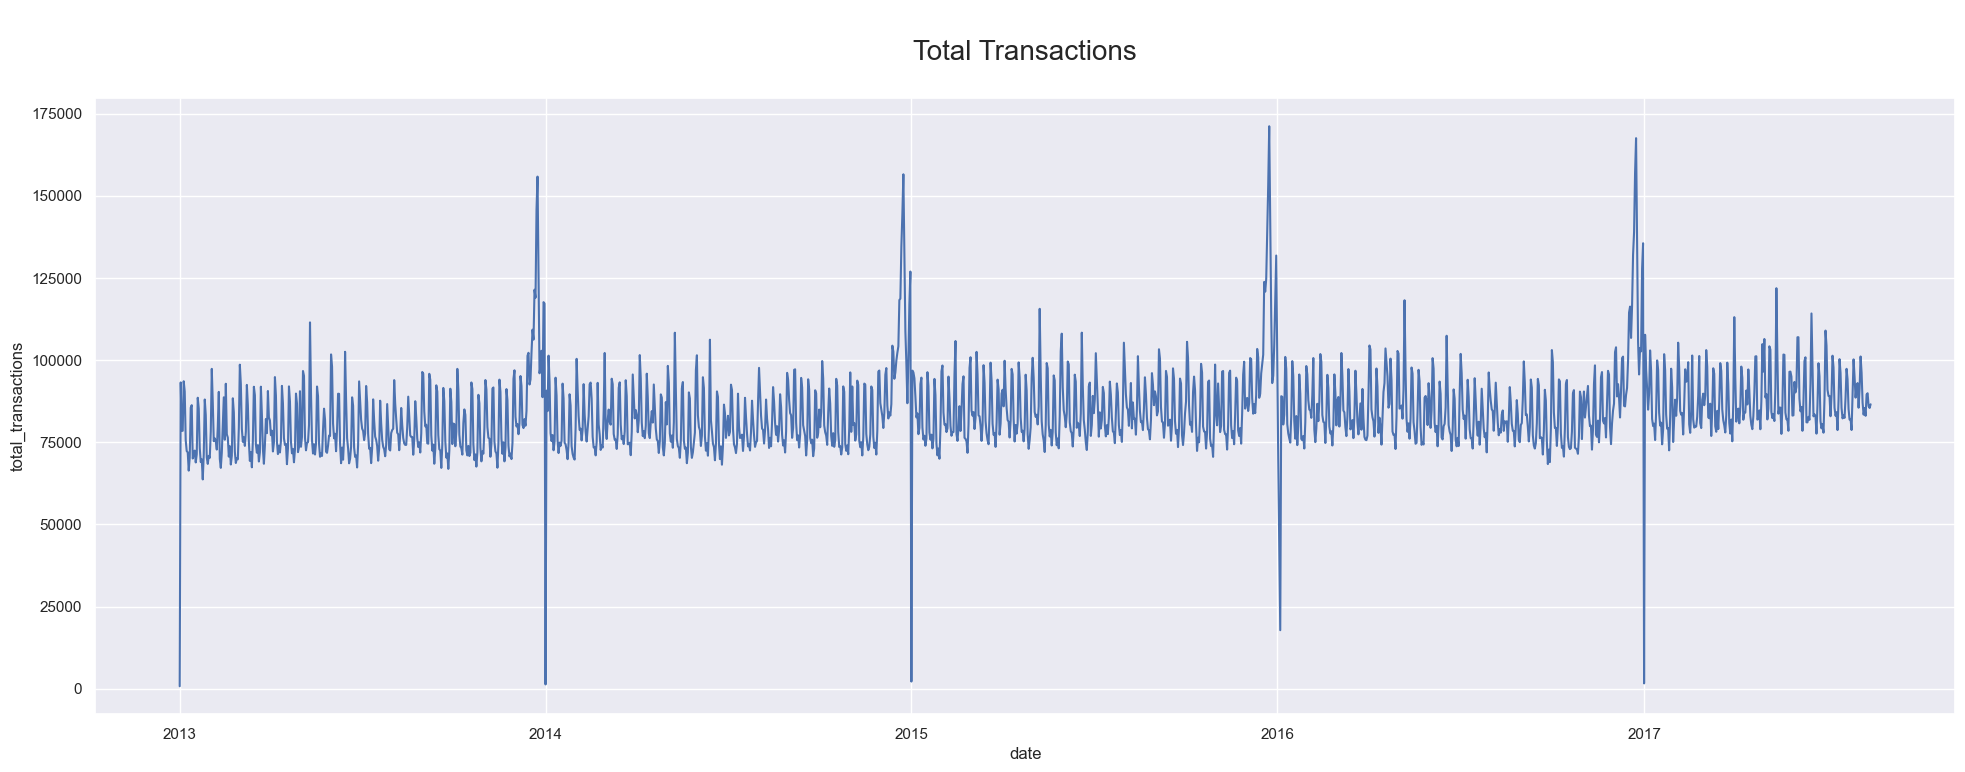

In [30]:
sns.set(rc={"figure.figsize":(24,8)})
ax=sns.lineplot(data=total_transactions,x="date",y="total_transactions")
ax.axes.set_title("\nTotal Transactions\n",fontsize=20);

In [31]:
total_transactions.sort_values('total_transactions', ascending=False).head(10)

,date,total_transactions
758,2015-12-24,171169
1359,2016-12-24,167542
1550,2016-12-23,156932
808,2014-12-24,156546
1579,2013-12-24,155846
657,2015-12-23,153338
692,2013-12-23,145876
995,2014-12-23,144513
18,2015-12-22,138921
375,2016-12-22,138892


In [32]:
total_transactions.sort_values('total_transactions', ascending=True).head(4)

,date,total_transactions
1095,2013-01-01,770
1594,2014-01-01,1327
427,2017-01-01,1642
1487,2015-01-01,2202


Christmas eve and just before is the busiest time, New Years Day is the quietest.

<AxesSubplot:xlabel='store_nbr', ylabel='avg_store_transactions'>

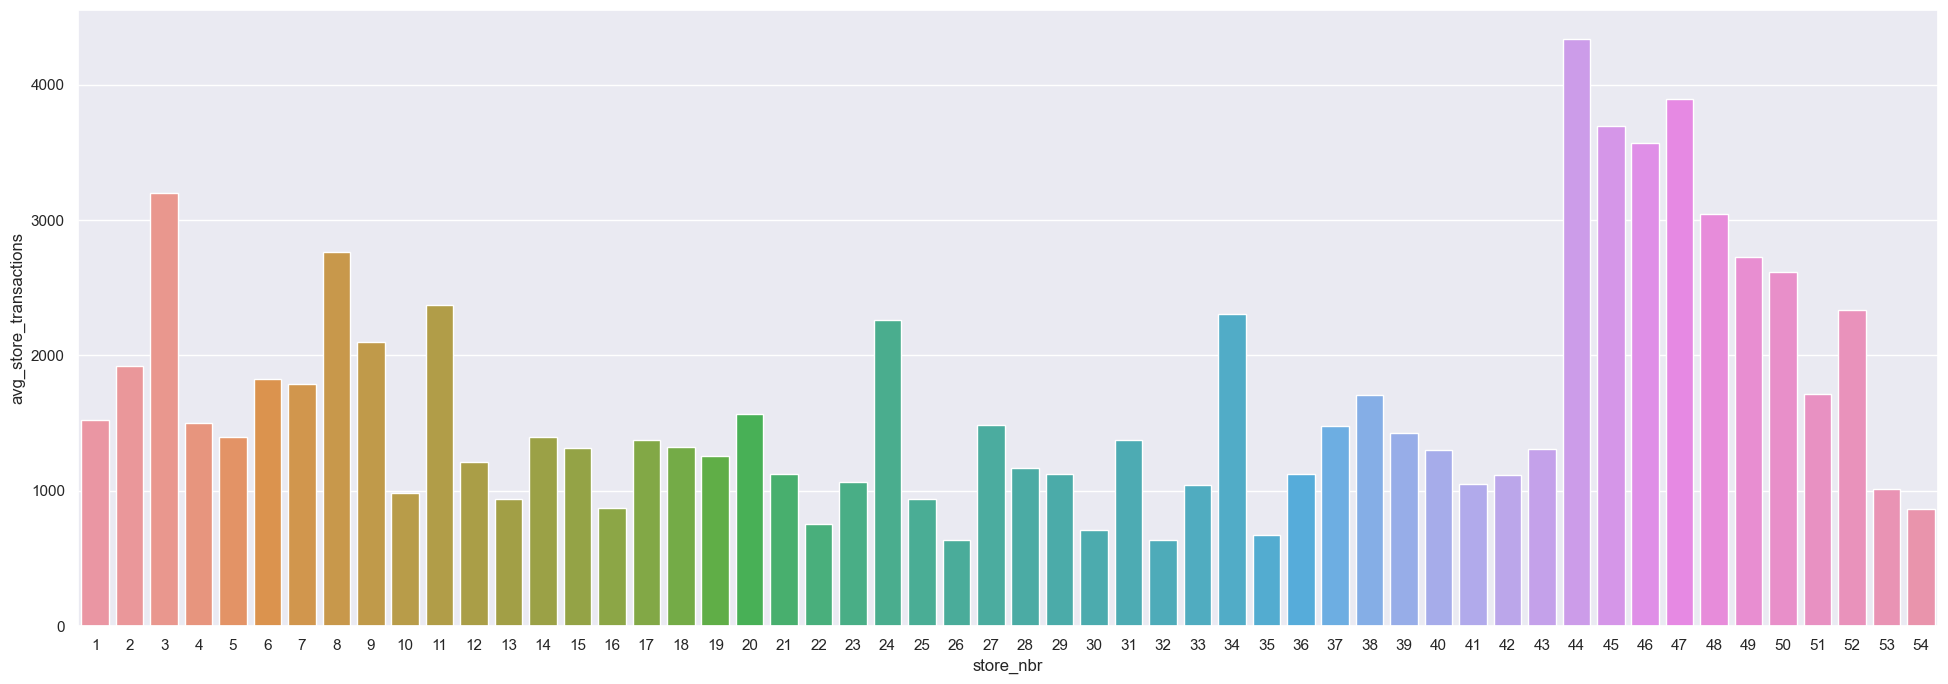

In [33]:
avg_transactions = transactions.select("store_nbr", "store_transactions")\
    .groupby(transactions.store_nbr)\
    .agg(sf.avg('store_transactions').alias('avg_store_transactions'))\
    .toPandas()
sns.barplot(x=avg_transactions.store_nbr, y=avg_transactions.avg_store_transactions)

Nothing too interesting, stores have different amounts of transactions. Chose to look at the average rather than total to control for stores being open longer than others.

Will see if the cluster or type aligns with this. Maybe type or cluster is based on traffic?

In [34]:
# Get store and txn info
stores = spark.read.parquet(str(proj.Config.paths.get("data_proc").joinpath("stores.parquet")))

# join store info to transactions
txns_stores = transactions.join(stores, transactions.store_nbr == stores.store_nbr, "left").drop(stores.store_nbr)
txns_stores.show(5)

+----------+---------+------------------+-------+-----------+----+-------+
|      date|store_nbr|store_transactions|   city|      state|type|cluster|
+----------+---------+------------------+-------+-----------+----+-------+
|2013-01-01|       25|               770|Salinas|Santa Elena|   D|      1|
|2013-01-02|        1|              2111|  Quito|  Pichincha|   D|     13|
|2013-01-02|        2|              2358|  Quito|  Pichincha|   D|     13|
|2013-01-02|        3|              3487|  Quito|  Pichincha|   D|      8|
|2013-01-02|        4|              1922|  Quito|  Pichincha|   D|      9|
+----------+---------+------------------+-------+-----------+----+-------+
only showing top 5 rows



<AxesSubplot:xlabel='cluster', ylabel='avg_store_transactions'>

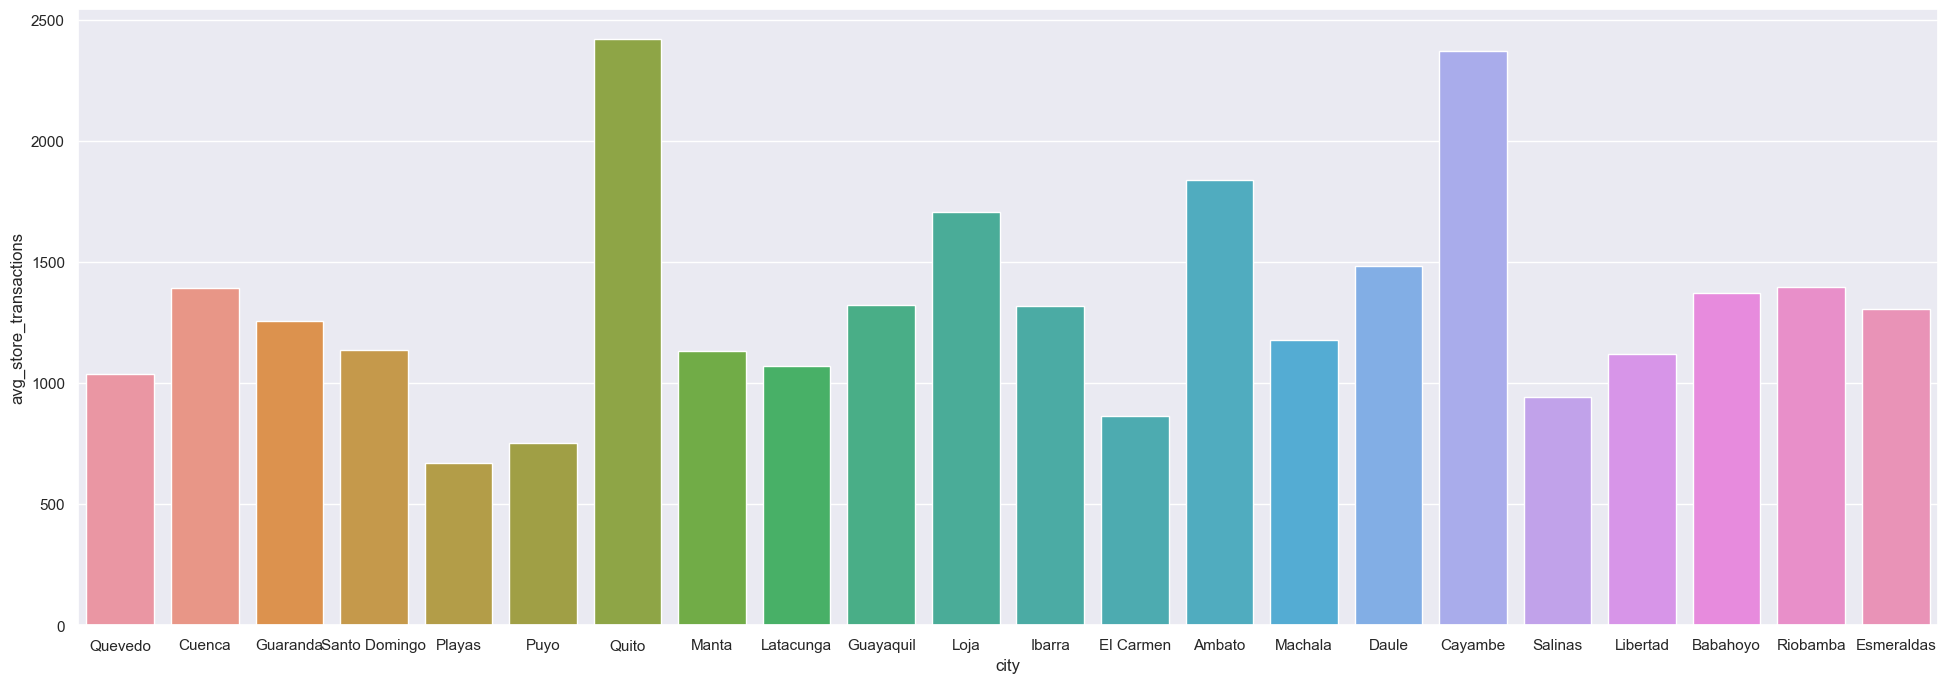

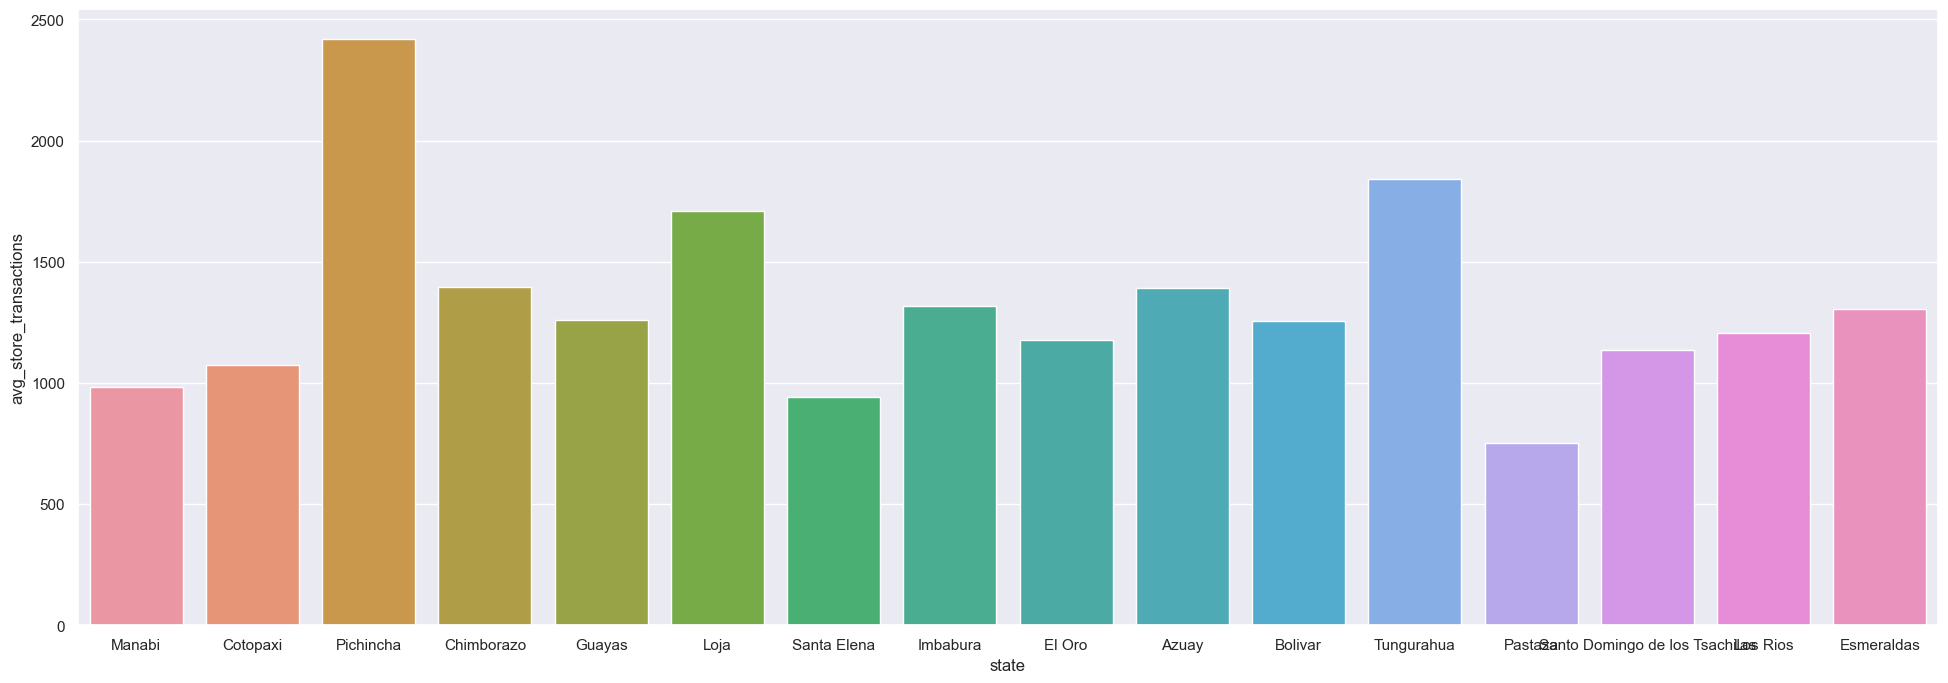

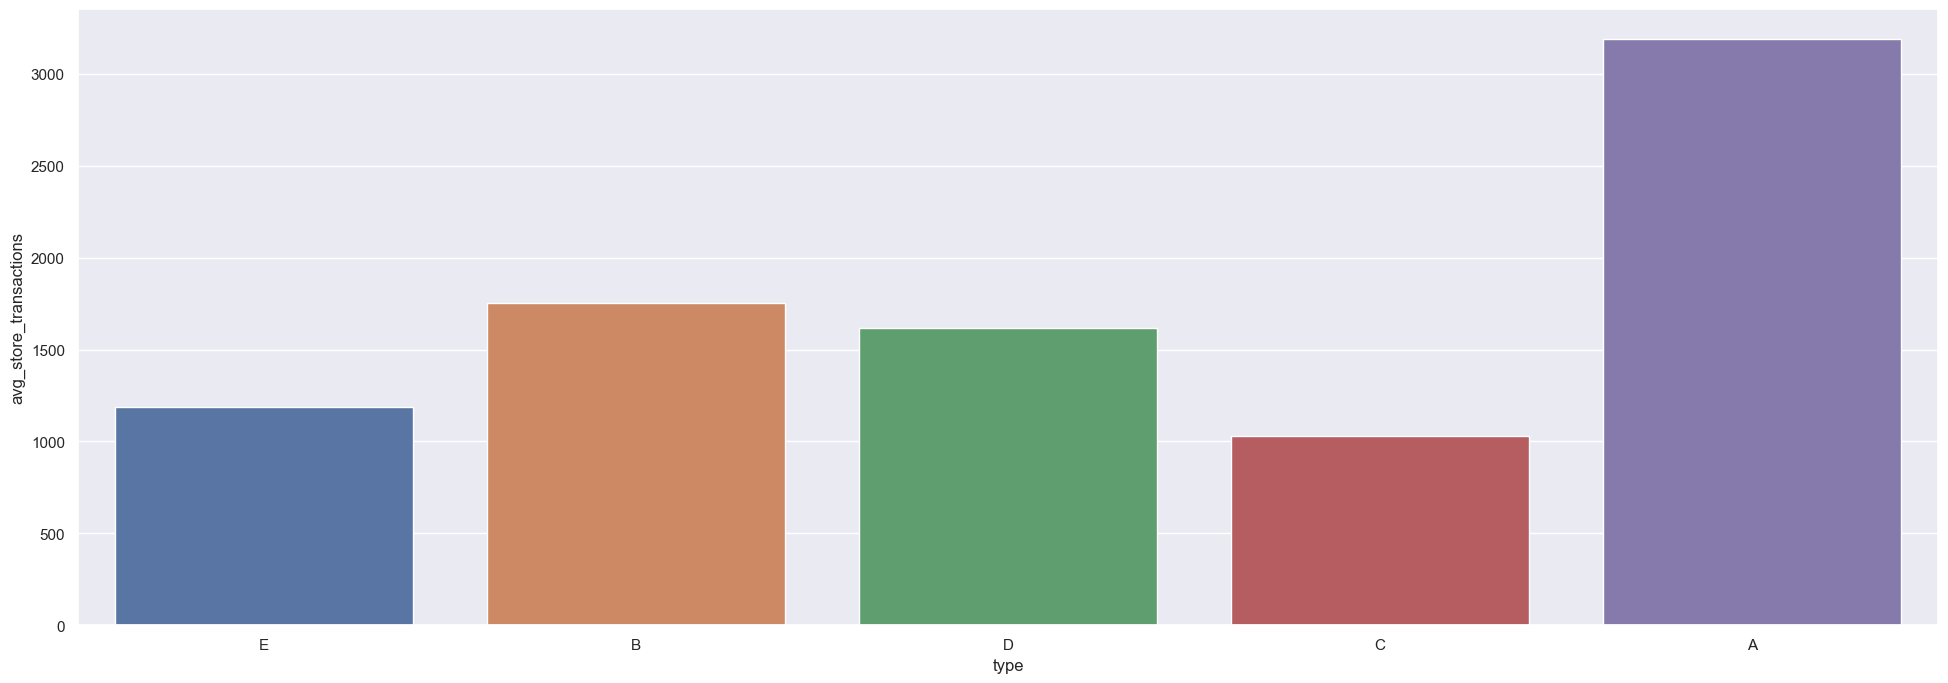

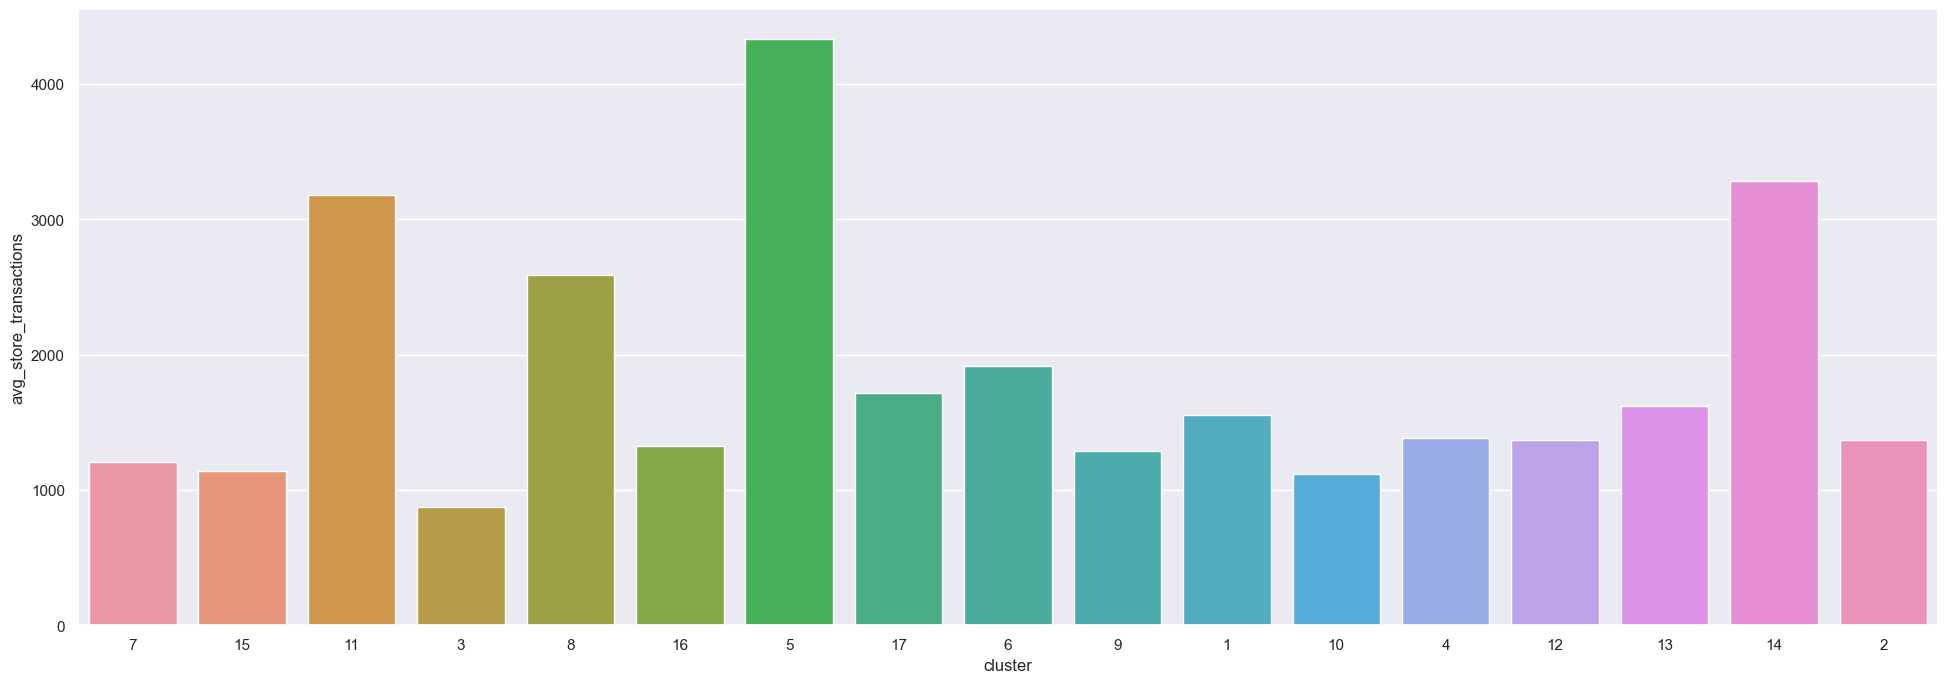

In [35]:
avg_city_transactions = txns_stores.select("city", "store_transactions")\
    .groupby(txns_stores.city)\
    .agg(sf.avg('store_transactions').alias('avg_store_transactions'))\
    .toPandas()

avg_state_transactions = txns_stores.select("state", "store_transactions")\
    .groupby(txns_stores.state)\
    .agg(sf.avg('store_transactions').alias('avg_store_transactions'))\
    .toPandas()

avg_type_transactions = txns_stores.select("type", "store_transactions")\
    .groupby(txns_stores.type)\
    .agg(sf.avg('store_transactions').alias('avg_store_transactions'))\
    .toPandas()

avg_cluster_transactions = txns_stores.select("cluster", "store_transactions")\
    .groupby(txns_stores.cluster)\
    .agg(sf.avg('store_transactions').alias('avg_store_transactions'))\
    .toPandas()


sns.barplot(x=avg_city_transactions.city, y=avg_city_transactions.avg_store_transactions)
plt.figure()
sns.barplot(x=avg_state_transactions.state, y=avg_state_transactions.avg_store_transactions)
plt.figure()
sns.barplot(x=avg_type_transactions.type, y=avg_type_transactions.avg_store_transactions)
plt.figure()
sns.barplot(x=avg_cluster_transactions.cluster, y=avg_cluster_transactions.avg_store_transactions)

Can see the high traffic states and cities from these barplots.
Also, store type A looks to be high traffic (at least higher traffic than other types)
Can also see some stand out clusters that have a lot of transactions.

#### Coverage of train and test

In [36]:
train = spark.read.parquet(str(proj.Config.paths.get("data_proc").joinpath("train.parquet")))
test = spark.read.parquet(str(proj.Config.paths.get("data_proc").joinpath("test.parquet")))
stores = spark.read.parquet(str(proj.Config.paths.get("data_proc").joinpath("stores.parquet")))

train_stores = train.select("store_nbr", sf.lit(1).alias("train_fl")).distinct()
test_stores = test.select("store_nbr", sf.lit(1).alias("test_fl")).distinct()

print(train_stores.count())
print(test_stores.count())
print(stores.select("store_nbr").distinct().count())

54
54
54


In [37]:
store_coverage = train_stores.join(test_stores, train_stores.store_nbr == test_stores.store_nbr, "full")
store_coverage.show(55)

+---------+--------+---------+-------+
|store_nbr|train_fl|store_nbr|test_fl|
+---------+--------+---------+-------+
|        1|       1|        1|      1|
|        2|       1|        2|      1|
|        3|       1|        3|      1|
|        4|       1|        4|      1|
|        5|       1|        5|      1|
|        6|       1|        6|      1|
|        7|       1|        7|      1|
|        8|       1|        8|      1|
|        9|       1|        9|      1|
|       10|       1|       10|      1|
|       11|       1|       11|      1|
|       12|       1|       12|      1|
|       13|       1|       13|      1|
|       14|       1|       14|      1|
|       15|       1|       15|      1|
|       16|       1|       16|      1|
|       17|       1|       17|      1|
|       18|       1|       18|      1|
|       19|       1|       19|      1|
|       20|       1|       20|      1|
|       21|       1|       21|      1|
|       22|       1|       22|      1|
|       23|       1|     

Train and test look to have the same store coverage, which is conveniant.

In [38]:
train_items = train.select("item_nbr", sf.lit(1).alias("train_fl")).distinct()
test_items = test.select("item_nbr", sf.lit(1).alias("test_fl")).distinct()

print(train_items.count())
print(test_items.count())

4036
3901


In [39]:
item_coverage = train_items.join(test_items, train_items.item_nbr == test_items.item_nbr, "full")

items_not_in_train = item_coverage.filter("train_fl is null").drop(train_items.item_nbr)
items_not_in_test = item_coverage.filter("test_fl is null").drop(test_items.item_nbr)

In [40]:
print("Items not in training but present in test")
print(items_not_in_train.count())

print("Items not in test but present in train")
print(items_not_in_test.count())

Items not in training but present in test


60
Items not in test but present in train


195


- 195 items have been cleared during the training period meaning they are not needed to be predicted for
- 60 items are introduced during the test period and will need to be handled as new items

## Need a feature store to continue EDA
More can be explored, but it helps to have a feature store with everything put together. This EDA will end here and a new one post feature store build will be done.

# Data wishlist
The following data would likely enrich any models built
- product pricing (not just a onpromotion flag)
- weather
- further promo information
- customer information